# Тест на нормальное распределение

In [7]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

Фильтрация данных


In [3]:
file_path = "D:/AI/Computerized-campimetry-test-analysis/summary_per_color_group.xlsx"
data = pd.read_excel(file_path)
necessary = data[data["id_test_attempt"]==0]
test_data = necessary.rename(columns=lambda x: x.replace('T258', 'CM')) #замена названий столбцов

In [4]:
data.head()

,Unnamed: 0,T258_dH+_red_mean,T258_dH+_red_std,T258_dH+_red_min,T258_dH+_red_25%,T258_dH+_red_50%,T258_dH+_red_75%,T258_dH+_red_max,T258_dH+_yellow_green_mean,T258_dH+_yellow_green_std,...,T278_SMR_diff_25%,T278_SMR_diff_50%,T278_SMR_diff_75%,T278_SMR_diff_max,T278_SMR_corr,T278_SMR_tau,id_test_attempt,id_sample,age,sex
0,61005,2.75,1.500000,1,1.75,3.0,4.00,4,1.00,0.816497,...,-0.111650,-0.003722,0.110599,0.298893,-0.348606,-0.231483,0,0,20.010959,1
1,47000,2.25,0.957427,1,1.75,2.5,3.00,3,0.75,0.500000,...,-0.051903,0.048618,0.063985,0.219723,0.102884,0.066421,0,1,20.013699,0
2,47466,1.75,0.957427,1,1.00,1.5,2.25,3,0.50,0.577350,...,-0.064603,-0.051664,0.073810,0.274372,-0.202019,-0.016667,0,2,20.112329,0
3,59980,2.00,0.816497,1,1.75,2.0,2.25,3,0.75,0.500000,...,-0.055315,-0.027076,0.070588,0.181467,0.019172,-0.049460,0,3,20.158904,0
4,47927,2.00,0.816497,1,1.75,2.0,2.25,3,0.25,0.500000,...,-0.129545,0.003198,0.072435,0.324830,-0.149060,-0.191063,1,4,20.158904,0


In [5]:
test_data = test_data[["CM_dH+_yellow_green_50%", "CM_dH+_blue_50%","CM_dH+_purple_50%","CM_dH+_red_50%"]]
test_data

,CM_dH+_yellow_green_50%,CM_dH+_blue_50%,CM_dH+_purple_50%,CM_dH+_red_50%
0,1.0,4457.5,4610.0,3.0
1,1.0,4519.0,9925.5,2.5
2,0.5,9886.5,6593.0,1.5
3,1.0,3710.0,4141.0,2.0
6,0.0,8748.5,7961.5,3.0
...,...,...,...,...
2988,10.0,16521.0,2616.5,7.5
2989,5.5,11435.0,9460.5,7.5
2990,6.5,29358.5,16345.5,10.0
2991,3.5,15058.5,9581.5,13.0


## Построение графиков qq plot

Графики, которые помогают визуально оценить, насколько данные соответствуют нормальному распределению.Если данные соответствуют нормальному распределению, точки лягут вдоль прямой.

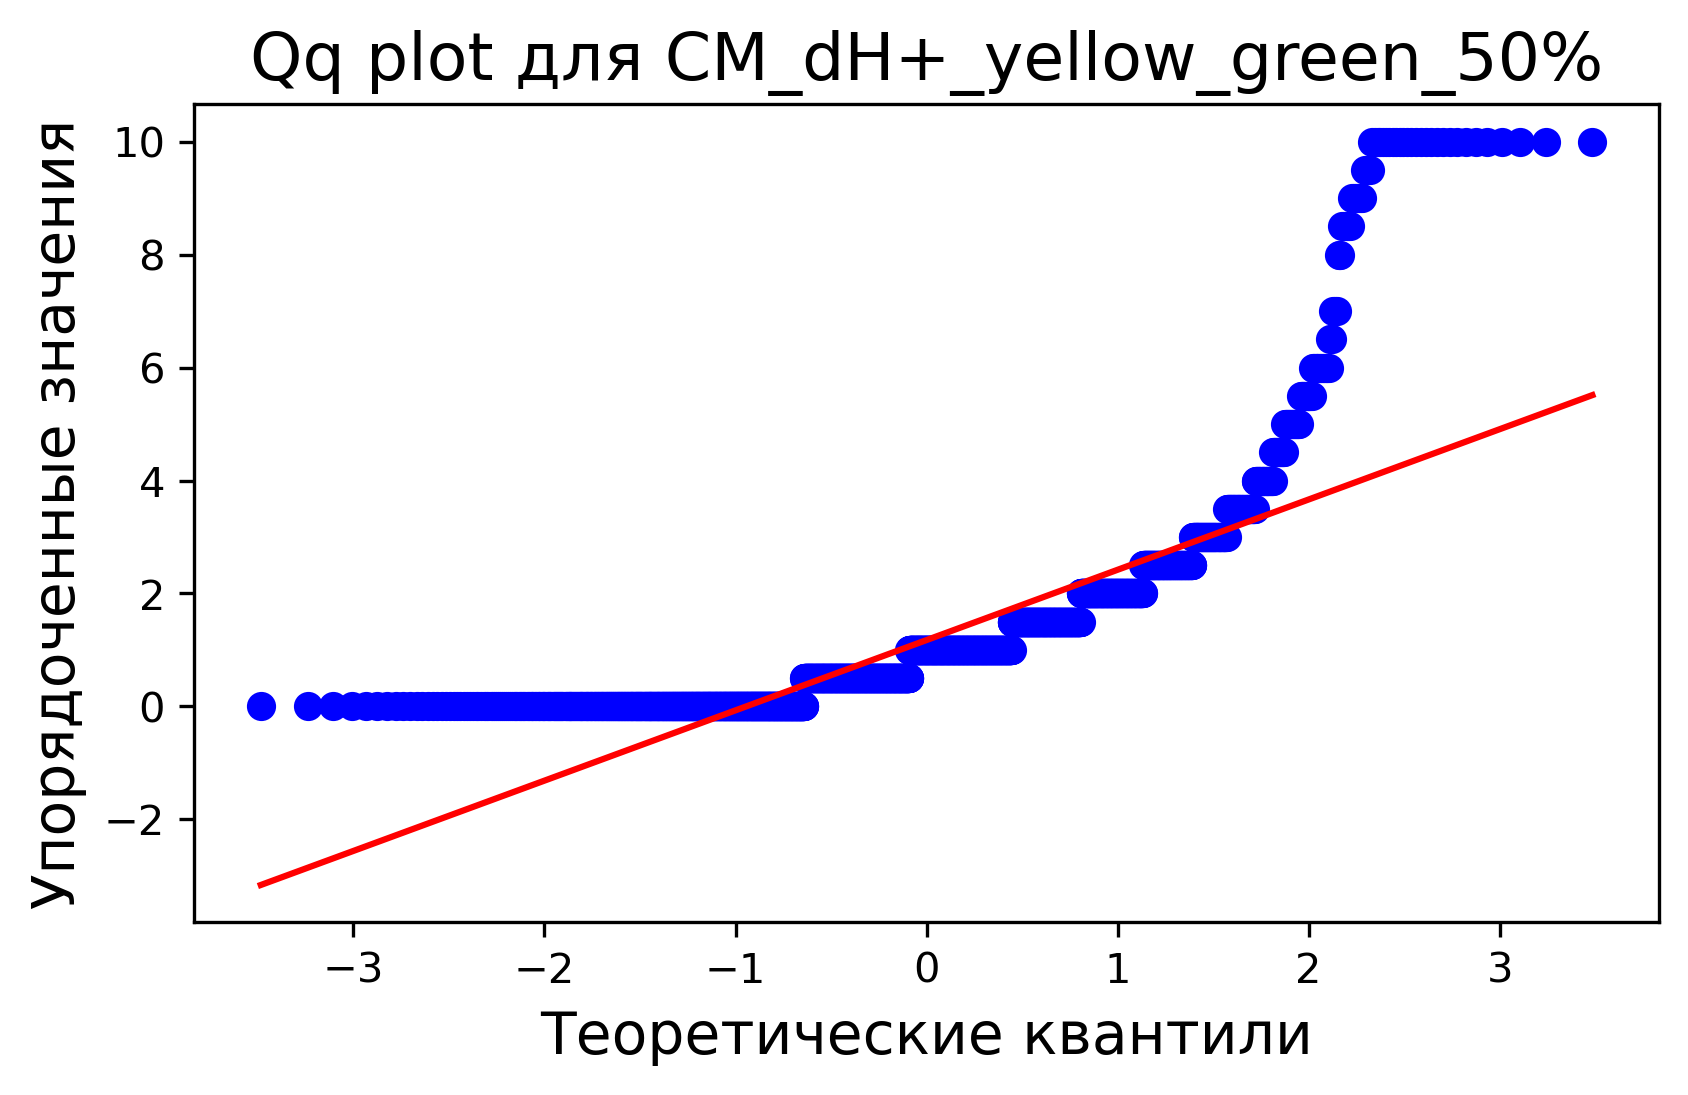

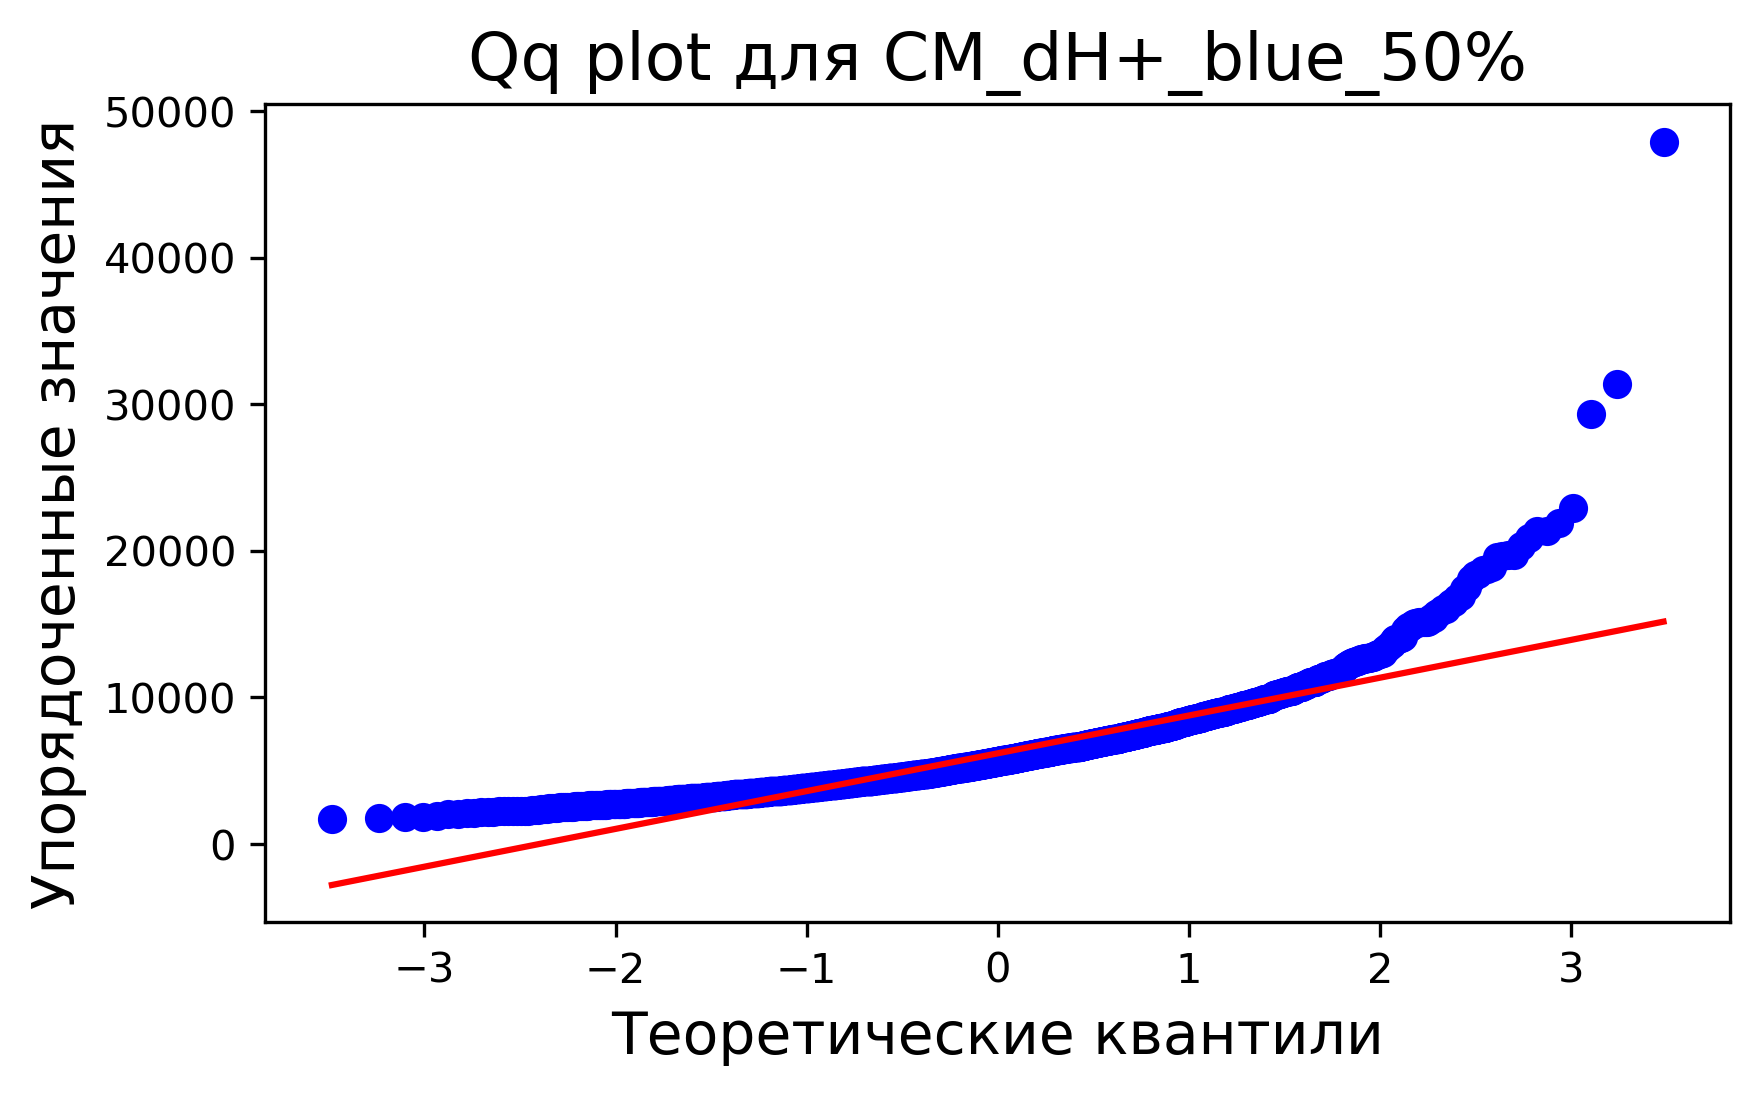

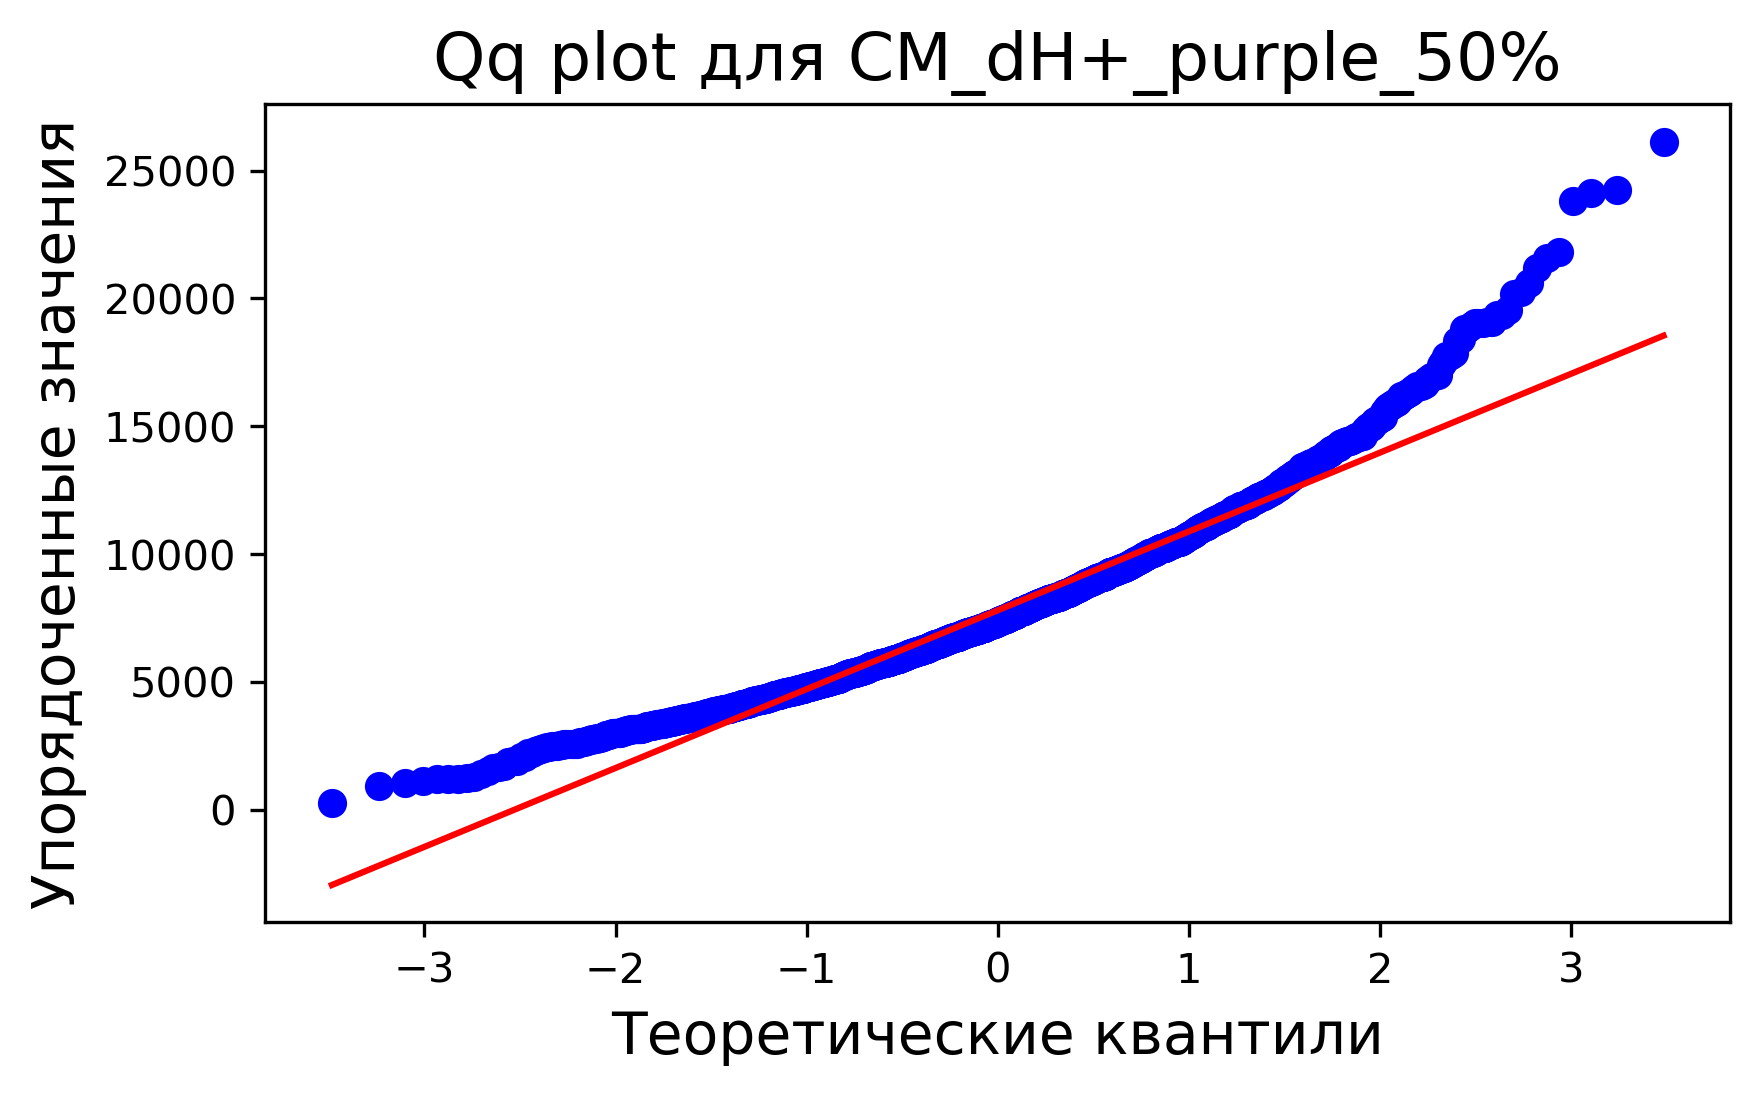

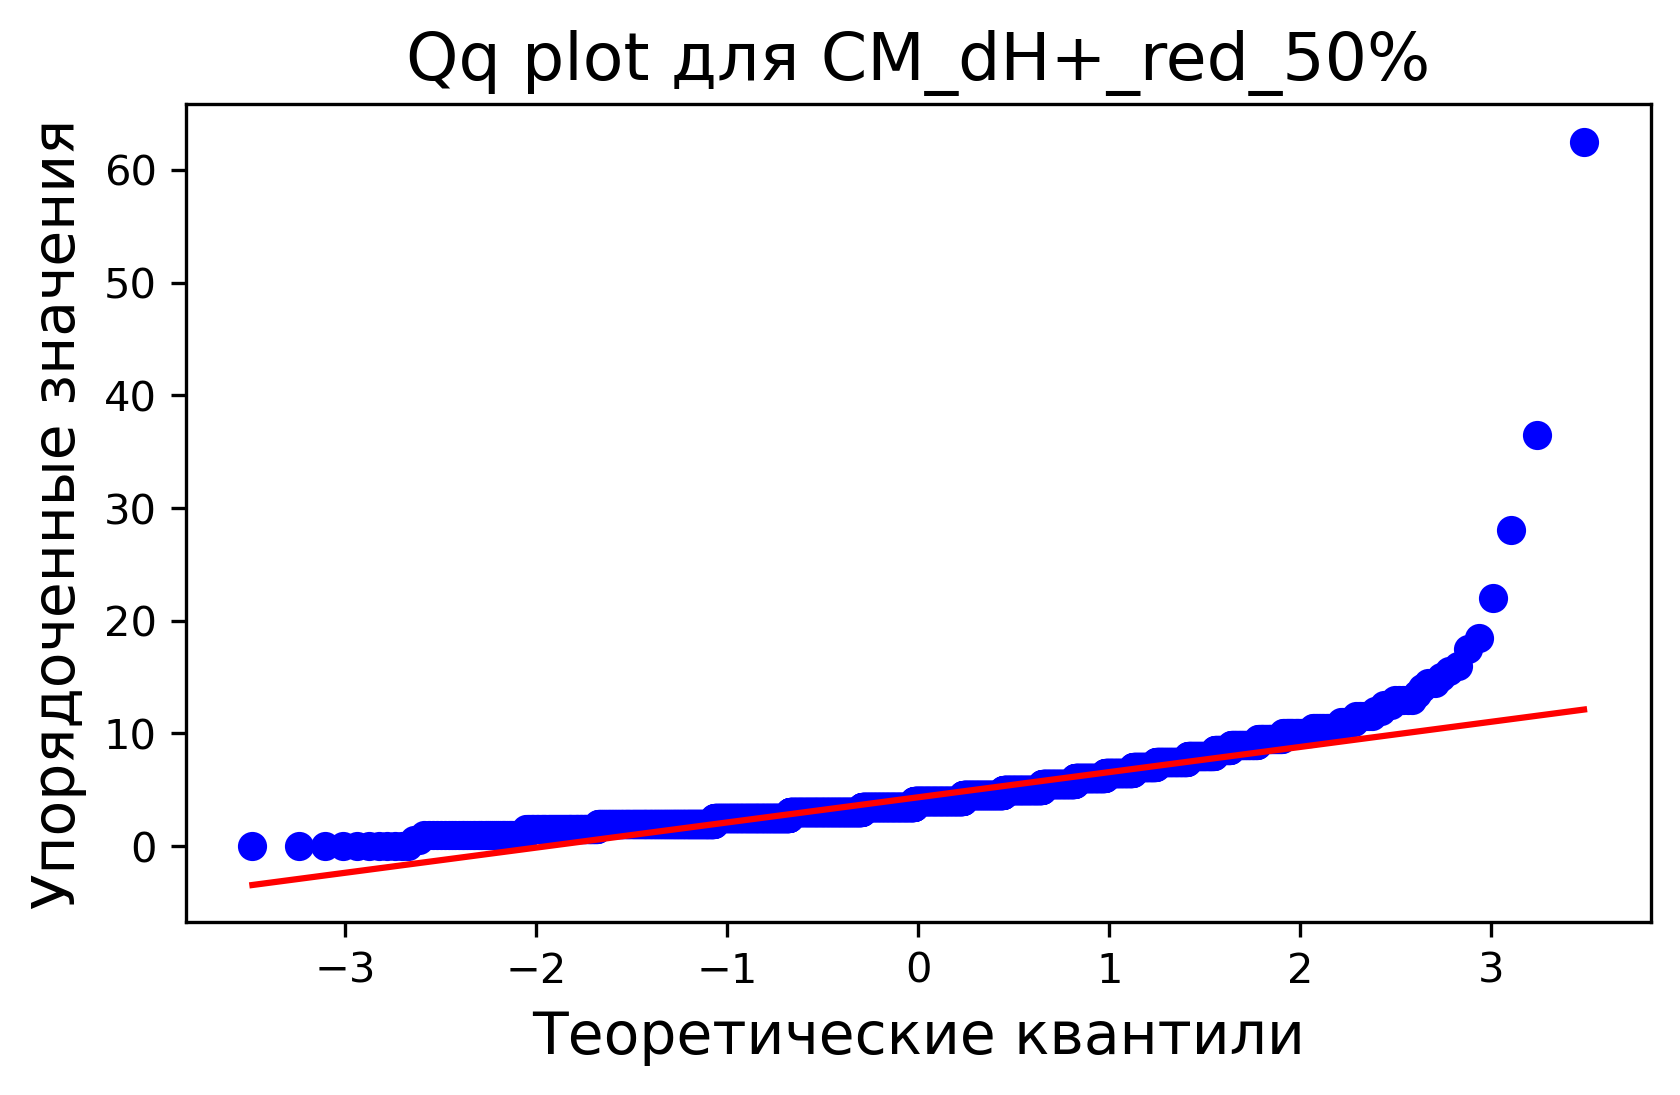

In [17]:
fig_width = 6.3  
fig_height = 3.54  


for column in test_data.columns:
    plt.figure(figsize=(fig_width,fig_height), dpi=300)
    stats.probplot(test_data[column], dist="norm", plot=plt)
    plt.title(f"Qq plot для {column}", fontsize=16, fontweight='light')
    plt.xlabel("Теоретические квантили", fontsize=14, fontweight='light')
    plt.ylabel("Упорядоченные значения", fontsize=14, fontweight='light')

## Тест Шапиро-Уилка

Статистический тест, который проверяет, насколько данные соответствуют нормальному распределению. Нулевая гипотеза (H0): данные имеют нормальное распределение. Альтернативная гипотеза (H1): данные не имеют нормального распределения.

In [24]:
columns = ["Столбец", "p-value", "Результат"]
result_table = pd.DataFrame(columns = columns)
for i, column in enumerate(test_data.columns):
    _, p_val = stats.shapiro(test_data[column]) # пропускается stat, где хранятся числа от 0 до 1(0- близко к нормальному, 1- сильное отклонение)
    if p_val < 0.05:
        status = "Гипотеза отклонена. Распределение не нормальное"
    else:
        status = "Гипотеза подтверждена. Распределение нормальное"
    result_table.loc[i] = [column, p_val, status]
# Настройка ширины таблицы и вывод на экран
pd.set_option('display.width', 130)
print(result_table)        

                   Столбец       p-value                                        Результат
0  CM_dH+_yellow_green_50%  0.000000e+00  Гипотеза отклонена. Распределение не нормальное
1          CM_dH+_blue_50%  0.000000e+00  Гипотеза отклонена. Распределение не нормальное
2        CM_dH+_purple_50%  7.526754e-29  Гипотеза отклонена. Распределение не нормальное
3           CM_dH+_red_50%  0.000000e+00  Гипотеза отклонена. Распределение не нормальное
